In [3]:
import importlib
import sys

modules_to_reload = [
    'games.ResourceGame',
    'policies.Policy',
    'games.games', 
    'policies.policies'  # Add this if you're using it elsewhere in your code
    'utils.utils'
]

for module in modules_to_reload:
    if module in sys.modules:
        importlib.reload(sys.modules[module])

import inspect
from games.ResourceGame import ResourceGame
from policies.Policy import Policy, OneStatePolicy, allPastStatePolicy
import games.games
import policies.policies
import torch
import torch.nn as nn
import utils.utils as utils
import matplotlib.pyplot as plt

def load_subclasses(path, parent_class):
    modules = importlib.import_module(path)
    subclasses = []
    for name, obj in inspect.getmembers(modules):
        print(name)
        if inspect.isclass(obj) and issubclass(obj, parent_class) and obj not in [parent_class, OneStatePolicy, allPastStatePolicy]:
            subclasses.append(obj)
    #instances = [subclass() for subclass in subclasses]
    return subclasses

games = load_subclasses('games.games', ResourceGame)
policies = load_subclasses('policies.policies', Policy)

print(games)
print(policies)

AlternatingRewardResourceGame
NonMarkovGame
NotSoSimpleResourceGame
OnlySpend10TimesResourceGame
ResourceGame
SimpleResourceGame
SpendingGoodInBeginning
SpendingGoodInEnd
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__spec__
np
BigBigPolicy
BigPolicy
OneStatePolicy
Policy
SimplePolicy
SmallPolicy
TransformerPolicy
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__spec__
allPastStatePolicy
betterTransformerPolicy
compute_subsequence_loss
nn
np
plt
torch
[<class 'games.games.AlternatingRewardResourceGame'>, <class 'games.games.NonMarkovGame'>, <class 'games.games.NotSoSimpleResourceGame'>, <class 'games.games.OnlySpend10TimesResourceGame'>, <class 'games.games.SimpleResourceGame'>, <class 'games.games.SpendingGoodInBeginning'>, <class 'games.games.SpendingGoodInEnd'>]
[<class 'policies.policies.BigBigPolicy'>, <class 'policies.policies.BigPolicy'>, <class 'policies.policies.SimplePolicy'>, <class 'policies.policies.SmallPolicy'>, <clas

In [2]:
torch.manual_seed(72)

print([policy.__name__ for policy in policies])
print([game.__name__ for game in games])
policy_class = policies[4]
game_class = games[1]

print(policy_class.__name__)
print(game_class.__name__)

policy = policy_class()
policy.plot_policy_heatmap()

['BigBigPolicy', 'BigPolicy', 'SimplePolicy', 'SmallPolicy', 'TransformerPolicy']
['AlternatingRewardResourceGame', 'NonMarkovGame', 'NotSoSimpleResourceGame', 'OnlySpend10TimesResourceGame', 'SimpleResourceGame', 'SpendingGoodInBeginning', 'SpendingGoodInEnd']
TransformerPolicy
NonMarkovGame


/Users/pennyb/miniconda3/envs/ims/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


'Not Implemented Yet!'

/Users/pennyb/Desktop/toy-transformer/RL/utils/utils.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  states = torch.FloatTensor(state_history).unsqueeze(0)


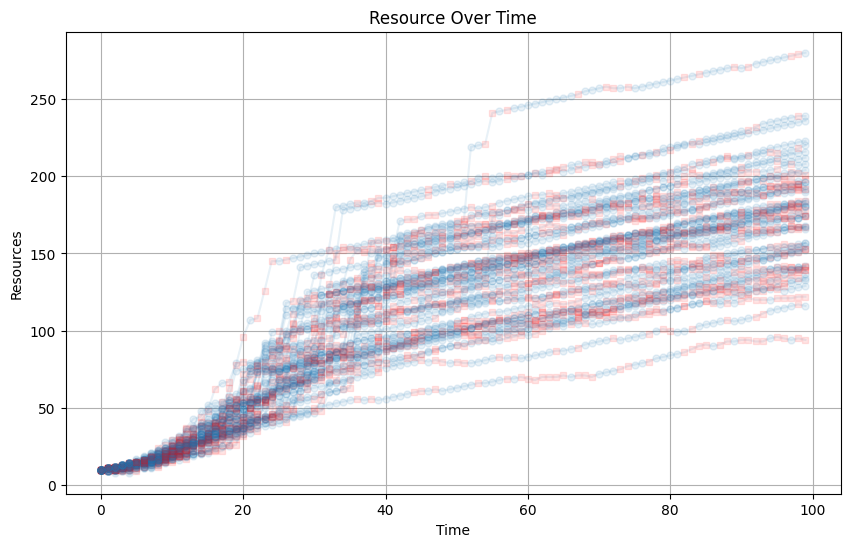

Final state - Time: 99, Resources: [152, 198, 167, 133, 142, 223, 157, 168, 166, 190, 129, 239, 236, 196, 181, 201, 184, 191, 208, 94, 204, 180, 139, 137, 134, 174, 174, 142, 178, 175, 153, 141, 116, 174, 183, 181, 167, 194, 192, 220, 155, 139, 212, 184, 153, 196, 157, 280, 122, 216]
(112.0556, 60.05260784212456)


In [4]:
trajectories = utils.sample_trajectories(policy, game_class, n=50, max_step=100)
utils.plot_rewards(trajectories)
print(utils.get_trajectories_mean(trajectories))

In [27]:
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(EmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self, x):
        if not isinstance(x, torch.LongTensor):
            x = x.long()
        return self.embedding(x)

In [100]:
import torch
import torch.nn as nn

class TransformerPolicy(allPastStatePolicy):
    def __init__(self, max_resource=1000, max_steps=100, input_action_vocab_size=3, output_action_vocab_size=2, d_model=6, nhead=3, num_layers=4, max_seq_length=100):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.max_resource = max_resource
        self.max_steps = max_steps
        self.action_vocab_size = input_action_vocab_size
        
        # Embeddings
        self.resource_embedding = nn.Embedding(max_resource + 1, d_model // 3)
        self.step_embedding = nn.Embedding(max_steps + 1, d_model // 3)
        self.action_embedding = nn.Embedding(input_action_vocab_size, d_model // 3)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, d_model))
        
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer
        self.fc_out = nn.Linear(d_model, output_action_vocab_size)

    def forward(self, states, action_history):
        # Process states
        resources, steps = zip(*states)
        resources = torch.tensor([min(r, self.max_resource) for r in resources]).unsqueeze(0)
        steps = torch.tensor([min(s, self.max_steps) for s in steps]).unsqueeze(0)
        
        # Process action history
        actions = torch.tensor(action_history).unsqueeze(0)
        
        # Determine the sequence length
        seq_len = max(resources.size(1), actions.size(1))
        
        # Pad sequences to match the longest sequence
        if resources.size(1) < seq_len:
            pad_length = seq_len - resources.size(1)
            resources = torch.nn.functional.pad(resources, (0, pad_length), value=self.max_resource)
            steps = torch.nn.functional.pad(steps, (0, pad_length), value=self.max_steps)
        if actions.size(1) < seq_len:
            pad_length = seq_len - actions.size(1)
            actions = torch.nn.functional.pad(actions, (0, pad_length), value=self.action_vocab_size-1)
        
        # Embed resources, steps, and actions
        resource_embed = self.resource_embedding(resources)
        step_embed = self.step_embedding(steps)
        action_embed = self.action_embedding(actions)
        
        # Combine embeddings
        x = torch.cat([resource_embed, step_embed, action_embed], dim=-1)
        
        # Add positional encoding
        x = x + self.positional_encoding[:, :x.size(1), :]
        
        # Transformer expects shape: (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)
        
        # Pass through Transformer
        x = self.transformer_encoder(x)
        
        # We're interested in the output for the last item in the sequence
        x = x[-1]
        
        # Output layer
        x = self.fc_out(x)
        
        return torch.softmax(x, dim=-1)

    def get_action(self, states, action_history):
        with torch.no_grad():
            action_probs = self.forward(states, action_history)
        return torch.multinomial(action_probs, 1).item()

In [101]:
policy = TransformerPolicy()

# Example state and action history
states = [[10,  0]]  # [[resource, step], ...]
action_history = [2]

# Get action probabilities
action_probs = policy(states, action_history)
print("Action probabilities:", action_probs)

# Get a specific action
action = policy.get_action(states, action_history)
print("Sampled action:", action)

Action probabilities: tensor([[0.7050, 0.2950]], grad_fn=<SoftmaxBackward0>)
Sampled action: 0


In [102]:
def get_loss_for_trajectory(trajectories, action_logs):
    def discount_rewards(trajectory, gamma=0.9):
        rewards = [t[2] for t in trajectory]
        discounted_rewards = torch.zeros_like(torch.tensor(rewards, dtype=torch.float32))
        R = 0
        for t in reversed(range(len(rewards))):
            R = rewards[t] + gamma * R
            discounted_rewards[t] = R
        return discounted_rewards

    losses = []
    for trajectory, action_log in zip(trajectories, action_logs):
        discounted_rewards = discount_rewards(trajectory)
        
        min_len = min(len(action_log), len(discounted_rewards))
        action_log = action_log[:min_len]
        discounted_rewards = discounted_rewards[:min_len]
        
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)
        
        episode_loss = -1 * (action_log * discounted_rewards).sum()
        losses.append(episode_loss)

    return torch.stack(losses).mean()

def reinforce(policy, game, optimizer, n=10):
    trajectories = []
    action_logs = []

    for _ in range(n):
        trajectory = []
        env = game()  # Assuming game() is defined elsewhere
        state = env.reset()
        episode_action_logs = []

        done = False
        while not done:
            if issubclass(policy.__class__, allPastStatePolicy):
                states = env.states
                actions = env.actions
                if actions == []:
                    actions = [2]
                action_probs = policy(states, actions)
            else:
                # Original behavior for non-transformer policies
                state_tensor = torch.FloatTensor(state)
                action_probs = policy(state_tensor)

            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()
            log_prob = action_distribution.log_prob(action)

            result = env.step(action.item())
            next_state, reward, done = result['state'], result['reward'], result['done']

            trajectory.append((state, action.item(), reward))
            episode_action_logs.append(log_prob)
            state = next_state

        trajectories.append(trajectory)
        action_logs.append(torch.stack(episode_action_logs))

    loss = get_loss_for_trajectory(trajectories, action_logs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss over time')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Epoch 0, Loss: 1.888275073724799e-05
Epoch 1, Loss: -1.8024444216280244e-05
Epoch 2, Loss: -2.899169885495212e-05
Epoch 3, Loss: 0.00015964507474564016
Epoch 4, Loss: -3.0088423955021426e-05
Epoch 5, Loss: 1.8405913579044864e-05
Epoch 6, Loss: -0.00017986298189498484
Epoch 7, Loss: 5.9413909184513614e-05
Epoch 8, Loss: 5.53131121705519e-06
Epoch 9, Loss: 1.721382068353705e-05
Epoch 10, Loss: 6.732940528308973e-05
Epoch 11, Loss: -0.00012073516700183973
Epoch 12, Loss: 6.030797885614447e-05
Epoch 13, Loss: -6.00337989453692e-05
Epoch 14, Loss: -0.00012068748765159398
Epoch 15, Loss: -0.00010046958777820691
Epoch 16, Loss: -5.626678466796875e-05
Epoch 17, Loss: -2.086162567138672e-05
Epoch 18, Loss: 1.2302398317842744e-05
Epoch 19, Loss: 5.9604644775390625e-06
Epoch 20, Loss: 3.9720536733511835e-05
Epoch 21, Loss: -3.2758711313363165e-05
Epoch 22, Loss: 3.814697265625e-05
Epoch 23, Loss: 2.670288040462765e-06
Epoch 24, Loss: 8.311271812999621e-05
Epoch 25, Loss: -8.263588097179309e-05
Ep

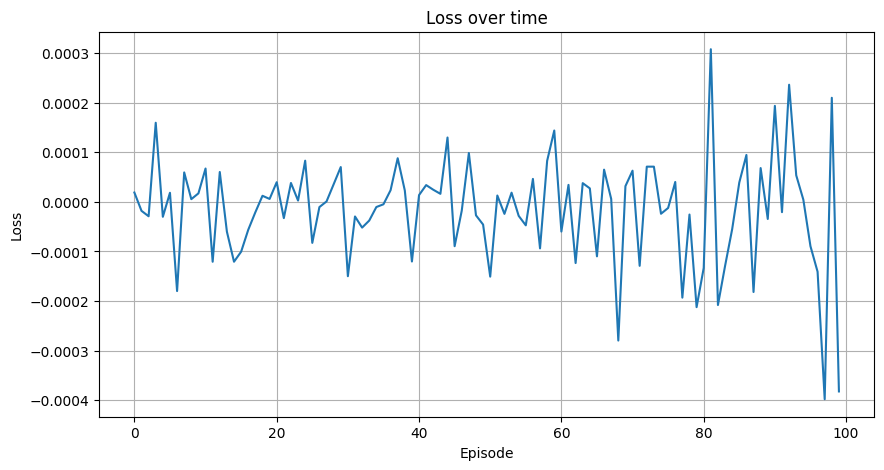

In [103]:
import torch.optim as optim

optimizer = optim.Adam(policy.parameters(), lr=0.01)

losses = []
for epoch in range(100):  # Run for 100 episodes
    loss = reinforce(policy, game_class, optimizer)
    losses.append(loss)
    print(f"Epoch {epoch}, Loss: {loss}")

policy.plot_policy_heatmap()

# Plot the losses

plot_loss(losses)

In [88]:
def sample_trajectories(policy, game, n=10, max_step=10):
    trajectories = []

    for _ in range(n):
        trajectory = []
        env = game() 
        state = env.reset()
        done = False
        step = 0

        while (not done) and (step < max_step):
            if issubclass(policy.__class__, allPastStatePolicy):
                actions = env.actions
                states = env.states

                if len(actions) == 0:
                    actions = [2]
                action_probs = policy(states, actions)
            else:
                # Original behavior for non-transformer policies
                state_tensor = torch.FloatTensor(state)
                action_probs = policy(state_tensor)

            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()

            result = env.step(action.item())
            next_state, reward, done = result['state'], result['reward'], result['done']

            trajectory.append((state, action.item(), reward))

            state = next_state
            step += 1
        trajectories.append(trajectory)
    return trajectories

trajectories = sample_trajectories(policy, game_class, n=50, max_step=100)

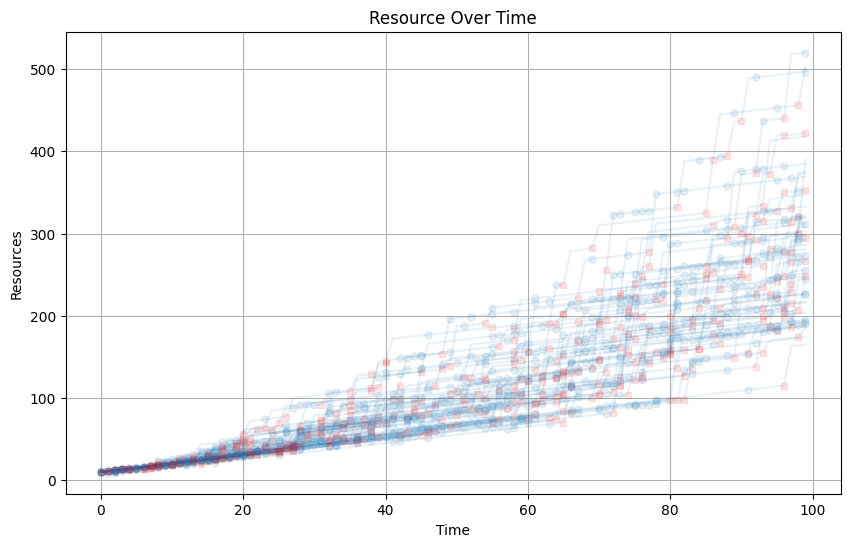

Final state - Time: 99, Resources: [303, 391, 194, 292, 256, 497, 312, 313, 297, 286, 187, 195, 226, 245, 294, 217, 333, 192, 227, 309, 269, 418, 204, 353, 375, 520, 248, 308, 347, 299, 385, 276, 188, 504, 246, 320, 216, 266, 422, 373, 322, 251, 174, 187, 190, 165, 319, 273, 281, 369]


(115.4924, 92.2632794899466)

In [94]:
utils.plot_rewards(trajectories)
utils.get_trajectories_mean(trajectories)

In [95]:
trajectories

[[(array([10,  0]), 2, 1),
  (array([11,  1]), 2, 1),
  (array([12,  2]), 2, 1),
  (array([13,  3]), 0, 1),
  (array([14,  4]), 2, 1),
  (array([15,  5]), 2, 1),
  (array([16,  6]), 2, 1),
  (array([17,  7]), 0, 1),
  (array([18,  8]), 2, 1),
  (array([19,  9]), 2, 1),
  (array([20, 10]), 1, 1),
  (array([21, 11]), 0, 1),
  (array([22, 12]), 2, 1),
  (array([23, 13]), 2, 1),
  (array([24, 14]), 2, 1),
  (array([25, 15]), 2, 1),
  (array([26, 16]), 2, 1),
  (array([27, 17]), 0, 1),
  (array([28, 18]), 2, 1),
  (array([29, 19]), 2, 1),
  (array([30, 20]), 2, 1),
  (array([31, 21]), 2, 1),
  (array([32, 22]), 2, 1),
  (array([33, 23]), 2, 1),
  (array([34, 24]), 2, 1),
  (array([35, 25]), 2, 1),
  (array([36, 26]), 2, 1),
  (array([37, 27]), 2, 1),
  (array([38, 28]), 2, 1),
  (array([39, 29]), 2, 1),
  (array([40, 30]), 2, 1),
  (array([41, 31]), 2, 1),
  (array([42, 32]), 0, 1),
  (array([43, 33]), 0, 1),
  (array([44, 34]), 2, 1),
  (array([45, 35]), 2, 1),
  (array([46, 36]), 2, 1),
 

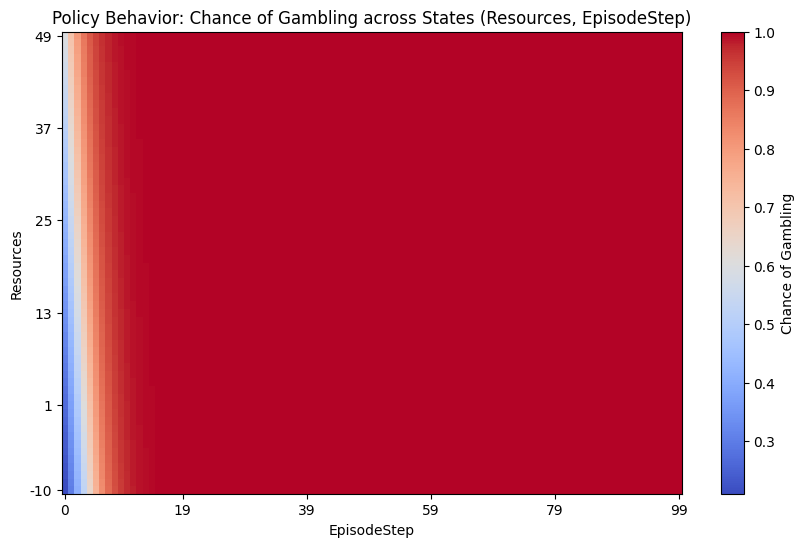

In [7]:
policy.plot_policy_heatmap()

[10  0]


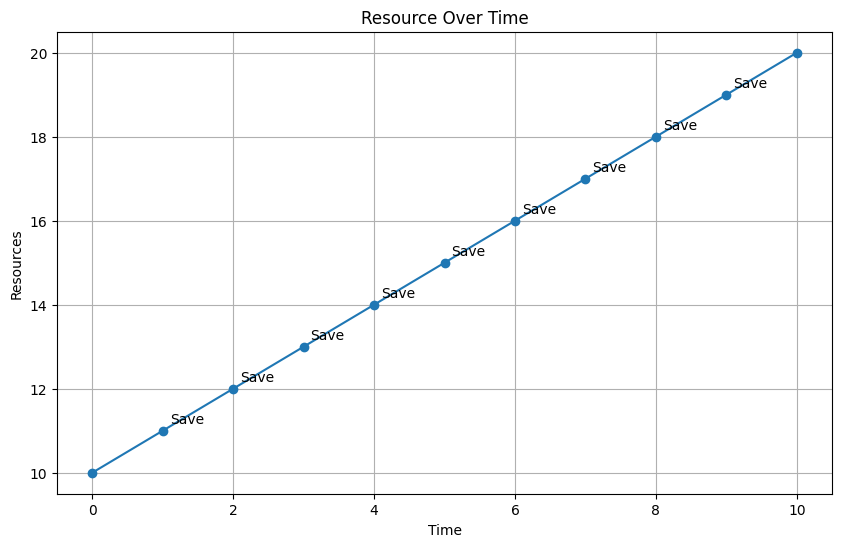

Final state - Time: 10, Resources: 20


In [ ]:
# Example usage
for t in range(1, 11):  # Run for 10 steps
    state = torch.FloatTensor(state)
    sampled_action = torch.multinomial(simplePolicy(state), num_samples=1).item()
    state, reward, done, _ = env.step(sampled_action)
    resources.append(state[0])
    times.append(t)
    actions.append('Spend' if sampled_action == 1 else 'Save')
    if done:
        break

plot_rewards(times, resources, actions)

In [ ]:
import torch.optim as optim

def train_policy(env, episodes=1000, lr=0.01):
    input_dim = 2  # resources and step_count
    output_dim = 2  # save or spend
    policy = SimplePolicy(input_dim, output_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        
        while True:
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)
            action = torch.multinomial(action_probs, num_samples=1).item()
            
            next_state, reward, done, _ = env.step(action)
            
            episode_reward = next_state[0]
            print(f"state: {state}, reward: {reward}")
            
            # Compute loss and update policy
            loss = -1 * torch.log(action_probs[action]) * reward
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            state = next_state
            
            if done:
                break
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Reward: {episode_reward}")
            policy.plot_policy_heatmap()
        # elif episode + 1 < 10:
        #     policy.plot_policy_heatmap()
        #     print(f"Episode {episode + 1}, Reward: {episode_reward}")

    return policy

state: [10  0], reward: 0
state: [10  1], reward: 1
state: [11  2], reward: 1
state: [12  3], reward: 3
state: [15  4], reward: 2
state: [17  5], reward: 1
state: [18  6], reward: 0
state: [18  7], reward: 1
state: [19  8], reward: -1
state: [18  9], reward: 0
state: [18 10], reward: 2
state: [20 11], reward: 1
state: [21 12], reward: 0
state: [21 13], reward: 1
state: [22 14], reward: -1
state: [21 15], reward: 0
state: [21 16], reward: 3
state: [24 17], reward: 2
state: [26 18], reward: 0
state: [26 19], reward: 0
state: [26 20], reward: 1
state: [27 21], reward: 0
state: [27 22], reward: 1
state: [28 23], reward: 0
state: [28 24], reward: 3
state: [31 25], reward: 3
state: [34 26], reward: 1
state: [35 27], reward: -1
state: [34 28], reward: -1
state: [33 29], reward: 3
state: [36 30], reward: 3
state: [39 31], reward: 0
state: [39 32], reward: -1
state: [38 33], reward: 2
state: [40 34], reward: 1
state: [41 35], reward: 3
state: [44 36], reward: 0
state: [44 37], reward: 2
state: 

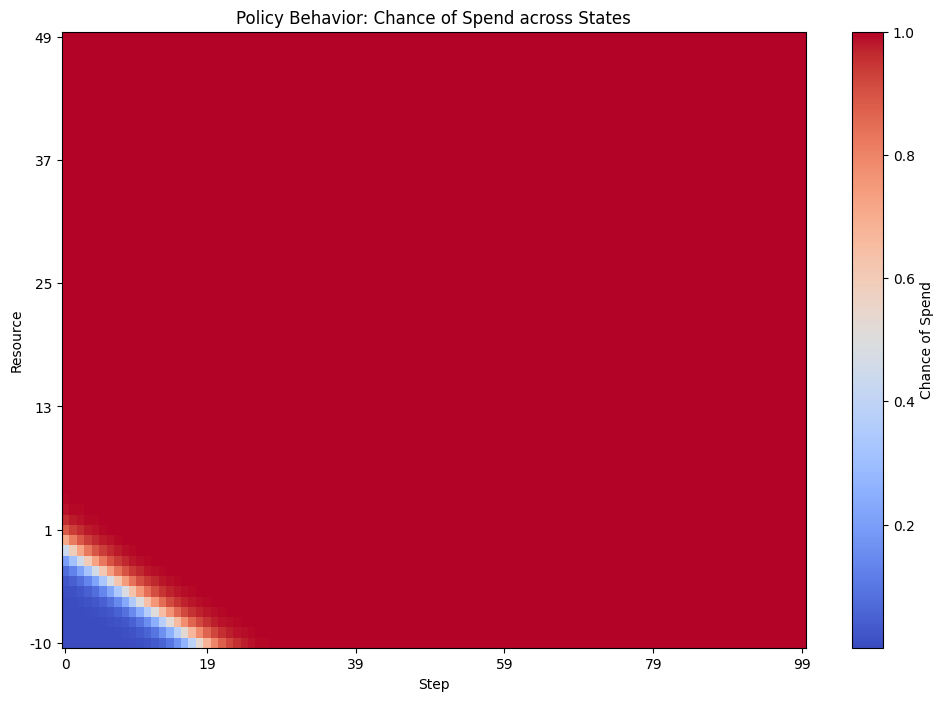

state: [10  0], reward: 0
state: [10  1], reward: -1
state: [9 2], reward: 0
state: [9 3], reward: -1
state: [8 4], reward: 3
state: [11  5], reward: -1
state: [10  6], reward: 3
state: [13  7], reward: 0
state: [13  8], reward: 1
state: [14  9], reward: 0
state: [14 10], reward: -1
state: [13 11], reward: -1
state: [12 12], reward: -1
state: [11 13], reward: -1
state: [10 14], reward: -1
state: [ 9 15], reward: 3
state: [12 16], reward: 1
state: [13 17], reward: 3
state: [16 18], reward: 2
state: [18 19], reward: 2
state: [20 20], reward: 0
state: [20 21], reward: 0
state: [20 22], reward: 2
state: [22 23], reward: 2
state: [24 24], reward: 0
state: [24 25], reward: 2
state: [26 26], reward: 0
state: [26 27], reward: 1
state: [27 28], reward: 2
state: [29 29], reward: 2
state: [31 30], reward: 3
state: [34 31], reward: 1
state: [35 32], reward: 2
state: [37 33], reward: 2
state: [39 34], reward: 1
state: [40 35], reward: 3
state: [43 36], reward: 1
state: [44 37], reward: 3
state: [47

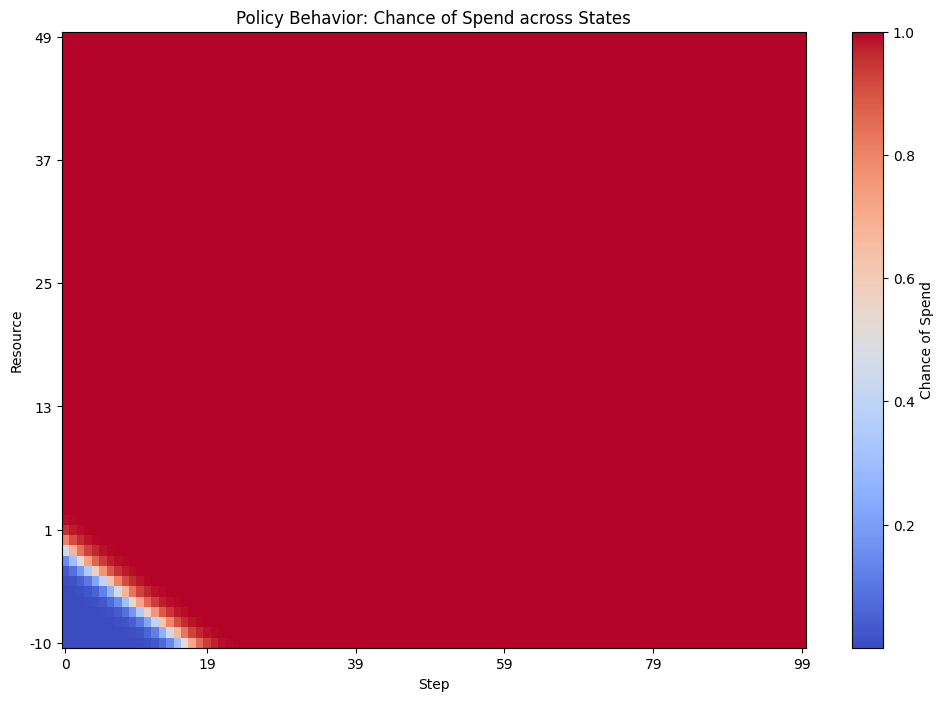

state: [10  0], reward: 3
state: [13  1], reward: 2
state: [15  2], reward: 1
state: [16  3], reward: 1
state: [17  4], reward: 1
state: [18  5], reward: 0
state: [18  6], reward: 0
state: [18  7], reward: 2
state: [20  8], reward: -1
state: [19  9], reward: 2
state: [21 10], reward: 1
state: [22 11], reward: 0
state: [22 12], reward: 0
state: [22 13], reward: 2
state: [24 14], reward: 2
state: [26 15], reward: 0
state: [26 16], reward: 1
state: [27 17], reward: 3
state: [30 18], reward: 2
state: [32 19], reward: -1
state: [31 20], reward: -1
state: [30 21], reward: -1
state: [29 22], reward: 1
state: [30 23], reward: 2
state: [32 24], reward: -1
state: [31 25], reward: 1
state: [32 26], reward: 0
state: [32 27], reward: 3
state: [35 28], reward: 2
state: [37 29], reward: -1
state: [36 30], reward: 2
state: [38 31], reward: 3
state: [41 32], reward: 0
state: [41 33], reward: 0
state: [41 34], reward: 2
state: [43 35], reward: 2
state: [45 36], reward: 1
state: [46 37], reward: -1
state

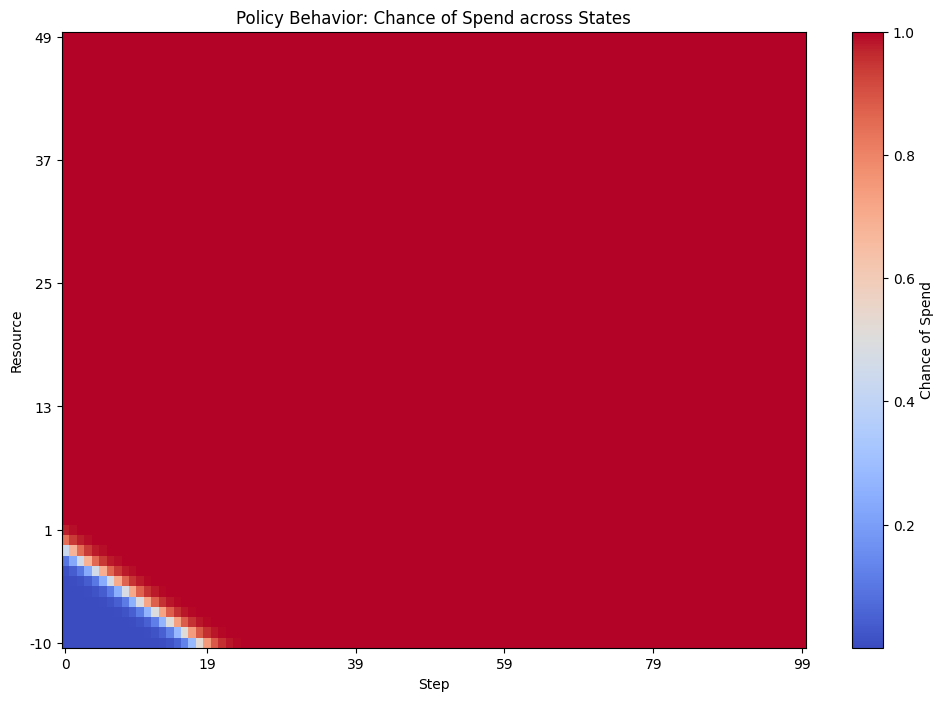

state: [10  0], reward: -1
state: [9 1], reward: 0
state: [9 2], reward: 2
state: [11  3], reward: 0
state: [11  4], reward: 3
state: [14  5], reward: 3
state: [17  6], reward: 0
state: [17  7], reward: 0
state: [17  8], reward: 3
state: [20  9], reward: 3
state: [23 10], reward: 3
state: [26 11], reward: -1
state: [25 12], reward: -1
state: [24 13], reward: 1
state: [25 14], reward: 3
state: [28 15], reward: 3
state: [31 16], reward: -1
state: [30 17], reward: -1
state: [29 18], reward: 1
state: [30 19], reward: 1
state: [31 20], reward: 1
state: [32 21], reward: -1
state: [31 22], reward: 0
state: [31 23], reward: 2
state: [33 24], reward: -1
state: [32 25], reward: 0
state: [32 26], reward: -1
state: [31 27], reward: 3
state: [34 28], reward: 3
state: [37 29], reward: -1
state: [36 30], reward: 0
state: [36 31], reward: 1
state: [37 32], reward: 0
state: [37 33], reward: 2
state: [39 34], reward: -1
state: [38 35], reward: -1
state: [37 36], reward: 2
state: [39 37], reward: 1
state

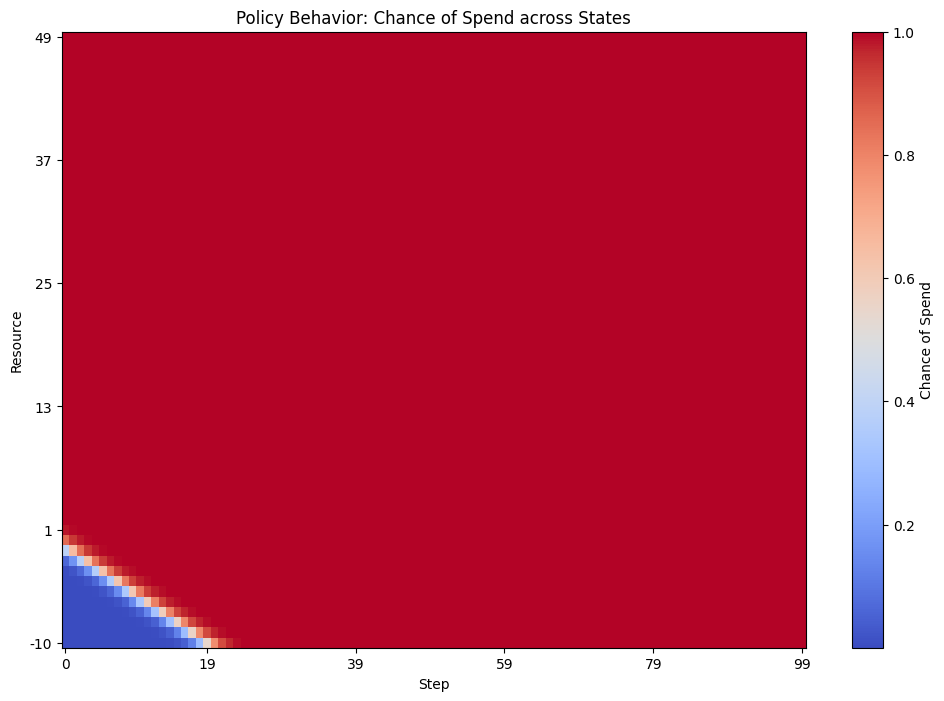

state: [10  0], reward: 1
state: [11  1], reward: 1
state: [12  2], reward: 0
state: [12  3], reward: 3
state: [15  4], reward: 0
state: [15  5], reward: 1
state: [16  6], reward: 0
state: [16  7], reward: 0
state: [16  8], reward: 0
state: [16  9], reward: 0
state: [16 10], reward: 3
state: [19 11], reward: 3
state: [22 12], reward: 2
state: [24 13], reward: -1
state: [23 14], reward: 0
state: [23 15], reward: 0
state: [23 16], reward: 1
state: [24 17], reward: 0
state: [24 18], reward: 3
state: [27 19], reward: 3
state: [30 20], reward: 1
state: [31 21], reward: 0
state: [31 22], reward: -1
state: [30 23], reward: 2
state: [32 24], reward: 3
state: [35 25], reward: -1
state: [34 26], reward: 1
state: [35 27], reward: 2
state: [37 28], reward: 2
state: [39 29], reward: -1
state: [38 30], reward: 2
state: [40 31], reward: 0
state: [40 32], reward: 0
state: [40 33], reward: 2
state: [42 34], reward: 0
state: [42 35], reward: 1
state: [43 36], reward: 1
state: [44 37], reward: 3
state: [

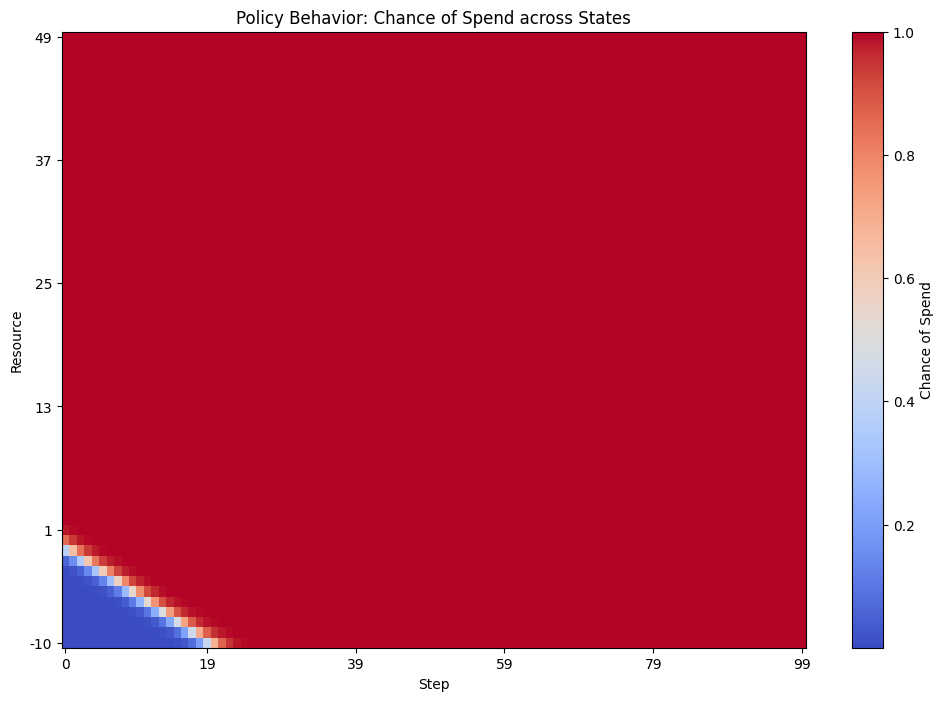

state: [10  0], reward: 3
state: [13  1], reward: -1
state: [12  2], reward: 3
state: [15  3], reward: 3
state: [18  4], reward: 1
state: [19  5], reward: 3
state: [22  6], reward: 0
state: [22  7], reward: -1
state: [21  8], reward: 1
state: [22  9], reward: -1
state: [21 10], reward: 1
state: [22 11], reward: 0
state: [22 12], reward: 1
state: [23 13], reward: 1
state: [24 14], reward: 1
state: [25 15], reward: 1
state: [26 16], reward: 1
state: [27 17], reward: 1
state: [28 18], reward: 1
state: [29 19], reward: 3
state: [32 20], reward: 1
state: [33 21], reward: 2
state: [35 22], reward: 0
state: [35 23], reward: 1
state: [36 24], reward: -1
state: [35 25], reward: 3
state: [38 26], reward: 1
state: [39 27], reward: -1
state: [38 28], reward: 0
state: [38 29], reward: 2
state: [40 30], reward: 3
state: [43 31], reward: -1
state: [42 32], reward: 1
state: [43 33], reward: 2
state: [45 34], reward: 3
state: [48 35], reward: 2
state: [50 36], reward: 3
state: [53 37], reward: 2
state:

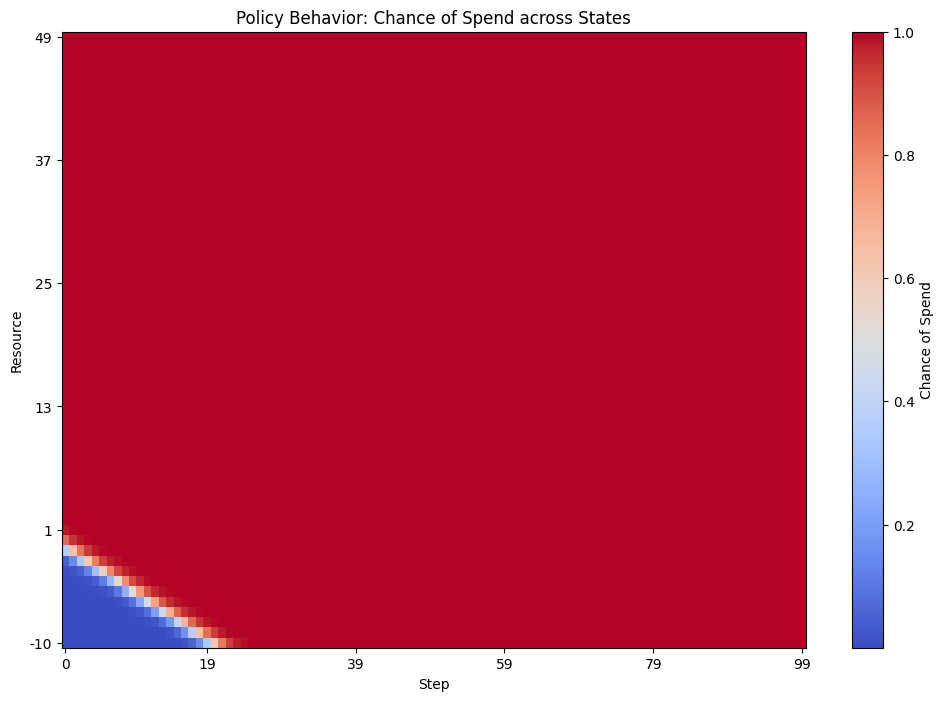

state: [10  0], reward: 0
state: [10  1], reward: 3
state: [13  2], reward: 0
state: [13  3], reward: 0
state: [13  4], reward: 3
state: [16  5], reward: -1
state: [15  6], reward: 2
state: [17  7], reward: 3
state: [20  8], reward: -1
state: [19  9], reward: 1
state: [20 10], reward: 2
state: [22 11], reward: 2
state: [24 12], reward: 3
state: [27 13], reward: -1
state: [26 14], reward: 3
state: [29 15], reward: 0
state: [29 16], reward: 2
state: [31 17], reward: -1
state: [30 18], reward: 1
state: [31 19], reward: -1
state: [30 20], reward: 2
state: [32 21], reward: -1
state: [31 22], reward: 0
state: [31 23], reward: 0
state: [31 24], reward: 2
state: [33 25], reward: 1
state: [34 26], reward: -1
state: [33 27], reward: 3
state: [36 28], reward: 2
state: [38 29], reward: 3
state: [41 30], reward: 1
state: [42 31], reward: 3
state: [45 32], reward: -1
state: [44 33], reward: 2
state: [46 34], reward: 0
state: [46 35], reward: 3
state: [49 36], reward: 1
state: [50 37], reward: 3
stat

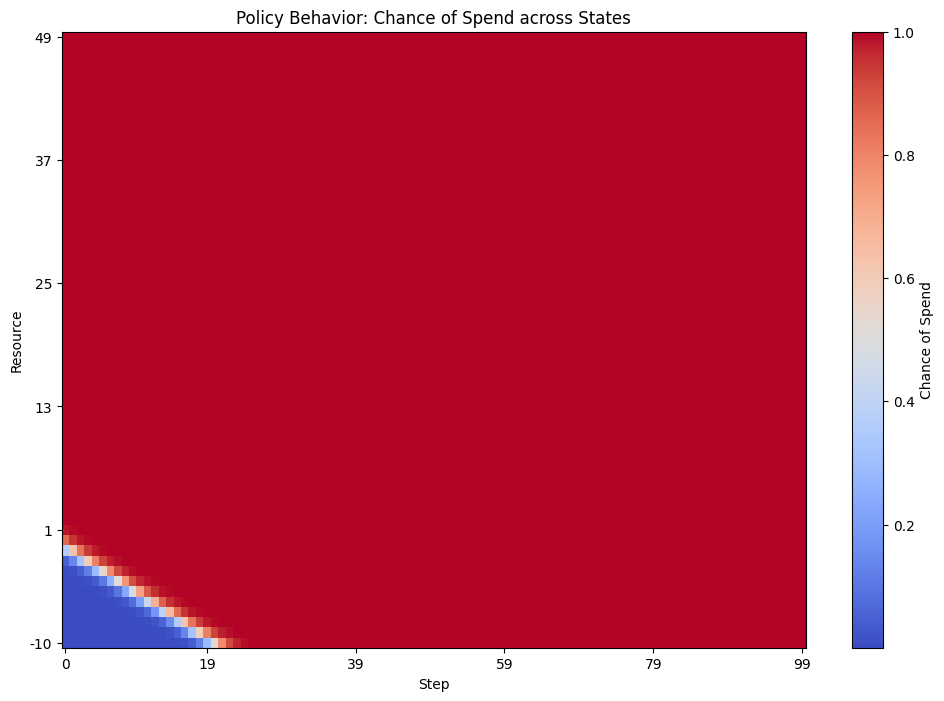

state: [10  0], reward: 0
state: [10  1], reward: 3
state: [13  2], reward: 0
state: [13  3], reward: 2
state: [15  4], reward: 0
state: [15  5], reward: 0
state: [15  6], reward: 2
state: [17  7], reward: -1
state: [16  8], reward: 1
state: [17  9], reward: 2
state: [19 10], reward: -1
state: [18 11], reward: 3
state: [21 12], reward: 0
state: [21 13], reward: 1
state: [22 14], reward: 2
state: [24 15], reward: 0
state: [24 16], reward: 1
state: [25 17], reward: 0
state: [25 18], reward: 1
state: [26 19], reward: 1
state: [27 20], reward: 3
state: [30 21], reward: -1
state: [29 22], reward: 0
state: [29 23], reward: 1
state: [30 24], reward: 3
state: [33 25], reward: 0
state: [33 26], reward: 1
state: [34 27], reward: 0
state: [34 28], reward: 3
state: [37 29], reward: 2
state: [39 30], reward: 3
state: [42 31], reward: 0
state: [42 32], reward: 3
state: [45 33], reward: -1
state: [44 34], reward: -1
state: [43 35], reward: -1
state: [42 36], reward: 0
state: [42 37], reward: 2
state:

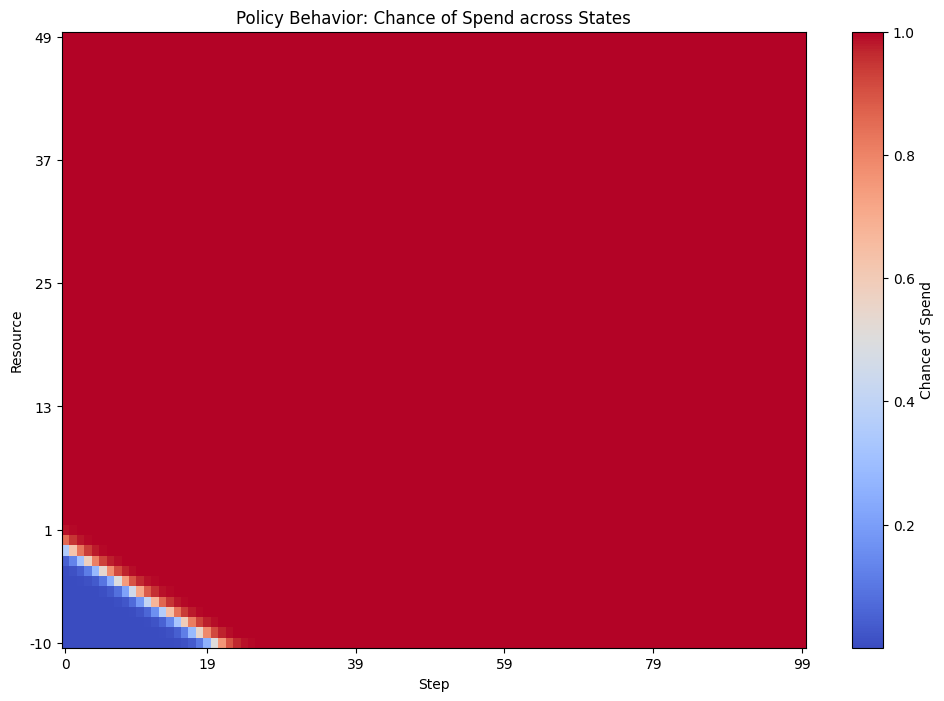

state: [10  0], reward: -1
state: [9 1], reward: 1
state: [10  2], reward: 3
state: [13  3], reward: 0
state: [13  4], reward: -1
state: [12  5], reward: 1
state: [13  6], reward: 3
state: [16  7], reward: 3
state: [19  8], reward: -1
state: [18  9], reward: 1
state: [19 10], reward: 0
state: [19 11], reward: 2
state: [21 12], reward: -1
state: [20 13], reward: -1
state: [19 14], reward: 3
state: [22 15], reward: 0
state: [22 16], reward: 0
state: [22 17], reward: -1
state: [21 18], reward: 2
state: [23 19], reward: 0
state: [23 20], reward: 2
state: [25 21], reward: 1
state: [26 22], reward: 3
state: [29 23], reward: -1
state: [28 24], reward: -1
state: [27 25], reward: -1
state: [26 26], reward: 2
state: [28 27], reward: 0
state: [28 28], reward: 2
state: [30 29], reward: 2
state: [32 30], reward: -1
state: [31 31], reward: -1
state: [30 32], reward: 2
state: [32 33], reward: 3
state: [35 34], reward: -1
state: [34 35], reward: 2
state: [36 36], reward: 0
state: [36 37], reward: 0
st

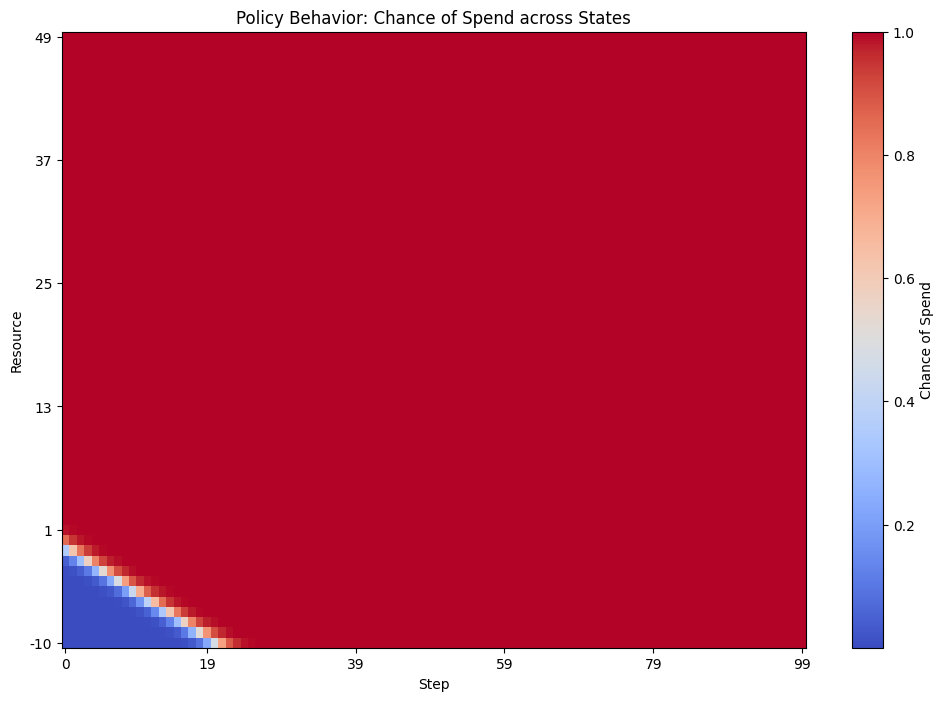

state: [10  0], reward: 1
state: [11  1], reward: 1
state: [12  2], reward: 1
state: [13  3], reward: 2
state: [15  4], reward: 0
state: [15  5], reward: 0
state: [15  6], reward: -1
state: [14  7], reward: 0
state: [14  8], reward: 0
state: [14  9], reward: 3
state: [17 10], reward: -1
state: [16 11], reward: 2
state: [18 12], reward: -1
state: [17 13], reward: -1
state: [16 14], reward: 3
state: [19 15], reward: -1
state: [18 16], reward: 2
state: [20 17], reward: 1
state: [21 18], reward: 3
state: [24 19], reward: 2
state: [26 20], reward: 3
state: [29 21], reward: 0
state: [29 22], reward: 2
state: [31 23], reward: 2
state: [33 24], reward: -1
state: [32 25], reward: 0
state: [32 26], reward: -1
state: [31 27], reward: 3
state: [34 28], reward: -1
state: [33 29], reward: 2
state: [35 30], reward: -1
state: [34 31], reward: 0
state: [34 32], reward: 2
state: [36 33], reward: 0
state: [36 34], reward: 1
state: [37 35], reward: 3
state: [40 36], reward: 1
state: [41 37], reward: 0
sta

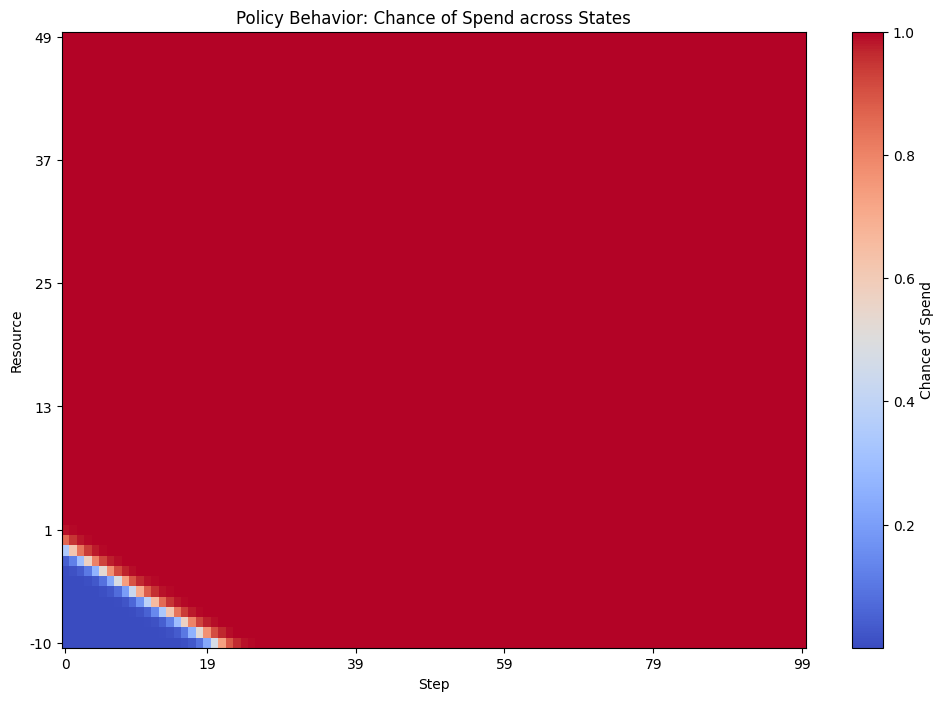

In [ ]:
# Train the agent
env = game()
trained_policy = train_policy(env)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming HarderResourceGame and trained_policy are defined elsewhere

test_episodes = 100
trained_rewards = []
always_spend_rewards = []
always_save_rewards = []
episode_numbers = []

for episode in range(test_episodes):
    env_trained = game()
    env_spend = game()
    env_save = game()

    state_trained = env_trained.reset()
    state_spend = env_spend.reset()
    state_save = env_save.reset()

    episode_trained_reward = 0
    episode_spend_reward = 0
    episode_save_reward = 0
    
    done = False
    while not done:
        # Trained policy
        state_tensor = torch.FloatTensor(state_trained)
        action_probs = trained_policy(state_tensor)
        action = torch.multinomial(action_probs, num_samples=1).item()
        state_trained, reward_trained, done, _ = env_trained.step(action)

        episode_trained_reward += reward_trained

        # Always spend policy
        state_spend, reward_spend, _, _ = env_spend.step(1)
        episode_spend_reward += reward_spend

        print(reward_spend)

        # Always save policy
        state_save, reward_save, _, _ = env_save.step(0)
       
    print()

    trained_rewards.append(episode_trained_reward)
    always_spend_rewards.append(episode_spend_reward)
    always_save_rewards.append(episode_save_reward)
    episode_numbers.append(episode + 1)

    print(f"Episode {episode + 1}: Trained: {episode_trained_reward:.2f}, "
          f"Always Spend: {episode_spend_reward:.2f}, "
          f"Always Save: {episode_save_reward:.2f}")

print(f"\nAverage Rewards over {test_episodes} episodes:")
print(f"Trained Policy: {np.mean(trained_rewards):.2f}")
print(f"Always Spend: {np.mean(always_spend_rewards):.2f}")
print(f"Always Save: {np.mean(always_save_rewards):.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, trained_rewards, label='Trained Policy')
plt.plot(episode_numbers, always_spend_rewards, label='Always Spend')
plt.plot(episode_numbers, always_save_rewards, label='Always Save')
plt.title('Reward over Time')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()

2
-1
-1
5
2
0
-1
15
0
25
52
0
105
32
175
1
108
236
502
620
99
1667
1648
5012
4434
8104
14197
15372
28116
27181
71410
147795
80193
67005
457790
893307
1684097
2701326
4378161
149751
5769378
4187048
734886
1177829
3762267
13004977
11842200
49204100
8597706
11429885
116552994
65056510
45523317
144344485
193690988
297434478
835143661
1580403914
1971790668
5061818432
5819307835
2213222847
3219319588
8421934936
26934678449
53922874881
90149318173
18847147329
215929278393
343774152096
728353533320
1374336594667
983177105379
2252338241497
5434704982628
1575523122628
9774242941352
20627431810897
33625660236992
9345018093749
84710642475411
22149763740260
185010432611731
7337313045812
114029583644407
265360406201733
351372270880290
219933790864819
1259987770424181
226406768049102
1437613654030516
1514848092830584
4833071649257998
3873839242056930
2094622029775364
7700105738989905
11326970761626208
25207288875065626
15720975780891250
23842129197564654

Episode 1: Trained: 100.00, Always Spend: 100

ValueError: high is out of bounds for int64

In [ ]:
always_spend_rewards

[-50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50]